In [1]:
import sys

sys.path.append("../")

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
import itertools as it
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [3]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOT', 'LINK', 'BCH', 'LTC', 'ALGO', 'MATIC', 'XLM', 'ETC']
symbols = [f'{s}-USDT' for s in symbols]

def get_data(start_date, end_date):
    data = []
    for symbol in symbols:
        try:
            file = f'{DATA_PATH}/{symbol}.csv'
            # print(file)
            df = pd.read_csv(file, 
                            parse_dates=['open_time'], 
                            index_col=['open_time'])
            df = df[(df.index > start_date) & (df.index < end_date)]
            df = df[~df.index.duplicated(keep='first')]
            df.rename(columns={'close': symbol}, inplace=True)
            # the data is too long, just limit to recent period
            data.append(np.log(df[symbol]))
        except:
            pass

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how='all')
    df.dropna(inplace=True, how='any')

    return df

In [4]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(df, symbol_pairs):
    cointegrating_pairs = []
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    #     print("trace_crit_value",trace_crit_value)
    #     print("eigen_crit_value",eigen_crit_value)
    #     print("lr1",result.lr1)
    #     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)
    
    return cointegrating_pairs



In [5]:
import traceback


critical_val = 0.005


def calculate_spread(df, coint_df, nb_symbols, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


def find_stationary_portfolio(df, coint_df, nb_symbols):
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            spread = calculate_spread(df, coint_df, nb_symbols, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            traceback.print_exc()
    
    stationary_df = pd.DataFrame(data)
    if len(stationary_df) > 0:
        stationary_df.sort_values(by=['half_life'], inplace=True)
    return stationary_df


# find_stationary_portfolio(df, coint_df, nb_symbols)


In [6]:
def zscore(x: pd.Series, window: int):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [30]:
start_date = '2021-02-01'
end_date = '2021-08-30'


df = get_data(start_date, end_date)
df.head()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOT-USDT,LINK-USDT,BCH-USDT,LTC-USDT,ALGO-USDT,MATIC-USDT,XLM-USDT,ETC-USDT
open_time,,,,,,,,,,,,,,
2021-02-01 01:00:00,10.417962,7.185523,-1.059786,3.791955,1.444846,-0.731057,2.779937,3.112359,5.989488,4.870223,-0.451143,-3.269380,-1.183974,2.009957
2021-02-01 02:00:00,10.424523,7.185387,-1.063110,3.792271,1.446660,-0.721135,2.779254,3.109641,5.994709,4.868995,-0.450986,-3.261001,-1.166902,2.008482
2021-02-01 03:00:00,10.422292,7.184091,-1.059988,3.798003,1.441303,-0.582322,2.773401,3.113071,5.997099,4.871680,-0.464260,-3.273068,-1.124761,2.009957
2021-02-01 04:00:00,10.422033,7.182709,-1.057768,3.804772,1.436916,-0.553733,2.778447,3.103016,6.006969,4.871756,-0.457917,-3.267279,-1.147845,2.017433
2021-02-01 05:00:00,10.427859,7.186901,-1.046143,3.817075,1.439503,-0.543349,2.774462,3.110266,6.019055,4.878855,-0.452085,-3.272013,-1.146648,2.030120


In [31]:
import traceback


nb_symbols = 2

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))
cointegrating_pairs = []

for pair in pairs:
    try:
        result = test_johansen(df, list(pair))
    except Exception:
        # traceback.print_exc()
        result = []

    cointegrating_pairs.extend(result)

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[2.1652953848742986, -2.1071166440520255]",BTC-USDT,BNB-USDT
1,"[3.0447395087191738, 1.5074866636649058]",BTC-USDT,XRP-USDT
2,"[10.608502253426128, -6.449954682006027]",BTC-USDT,DOT-USDT
3,"[0.6146585218367211, 3.2363894006699234]",BTC-USDT,BCH-USDT
4,"[2.4251144305534127, -4.977115250949126]",BTC-USDT,LTC-USDT


In [32]:
stationary_df = find_stationary_portfolio(df, coint_df, nb_symbols)
stationary_df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,i,pairs,half_life
30,30,"[LINK-USDT, XLM-USDT]",58
33,33,"[LTC-USDT, XLM-USDT]",63
28,28,"[LINK-USDT, LTC-USDT]",74
26,26,"[DOT-USDT, ALGO-USDT]",79
36,36,"[ALGO-USDT, XLM-USDT]",79
32,32,"[LTC-USDT, ALGO-USDT]",84
5,5,"[BTC-USDT, ALGO-USDT]",99
29,29,"[LINK-USDT, ALGO-USDT]",109
35,35,"[ALGO-USDT, MATIC-USDT]",148
12,12,"[ADA-USDT, SOL-USDT]",150


In [33]:
i = 30
selected = coint_df.iloc[i].to_dict()
selected['pair'] = list(stationary_df.loc[i].pairs)
selected['half_life'] = stationary_df.loc[i].half_life
# stationary_df.loc[i]
selected

{'hedge_ratio': array([ 11.65221208, -11.1925474 ]),
 'sid_1': 'LINK-USDT',
 'sid_2': 'XLM-USDT',
 'pair': ['LINK-USDT', 'XLM-USDT'],
 'half_life': 58}

In [34]:
spread = calculate_spread(df, coint_df, nb_symbols, i, selected['hedge_ratio'])
spread.dropna(inplace=True)
# spread

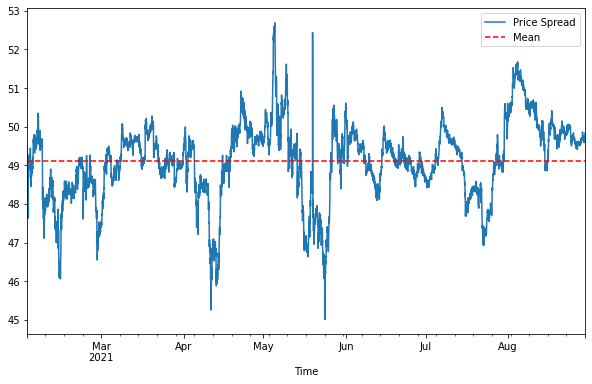

In [35]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])
plt.show()

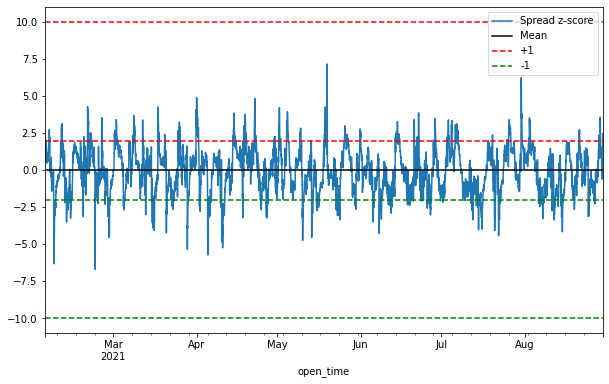

In [36]:
z = zscore(spread, selected['half_life'])
z.dropna(inplace=True)
z.plot()
plt.axhline(0, color='black')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.axhline(-10, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.show()

In [ ]:
class PairStrategy(Strategy):
    def init(self):
        